## LOAD DATA

In [1]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

In [3]:
import os
from google.colab import drive
drive.mount("/content/drive")

os.chdir('drive/My Drive/Colab Notebooks')
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
df = pd.read_csv('data/Clothing-Reviews.csv')

In [5]:
df.shape

(50046, 6)

In [6]:
df.head()

,asin,title,review_userId,review_score,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...
2,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2F9LXG1QEJ855,4,Very Original Debut of one of the most striden...,"This is an early, and rough-sounding look at t..."
3,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2FGXHSHF0OD17,5,No secret here,Whats to say about this album? Quintessential ...
4,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2O2E8BLB7VW1U,5,Brings a smile to my face...,...Whenever i listing to an album by incantati...


In [7]:
#Quick change: rename "asin" to itemID for easy look
df.rename(columns={"asin": "itemId", "review_score" : "rating", "review_userId" : "userId"}, inplace = True);

In [8]:
df.head(1)

,itemId,title,userId,rating,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."


In [9]:
df.tail()

,itemId,title,userId,rating,review_summary,review_text
50041,B06WV7M6RZ,Hooked Up by IOT Womens Juniors Ribbed Knit St...,A1F88FF6M96VV0,5,Fantastic!!,I wish I had found these years ago. Ive been d...
50042,B06WV7M6RZ,Hooked Up by IOT Womens Juniors Ribbed Knit St...,A1G5NAOPKGZEFL,5,These work!,I just have to say that if youre looking for n...
50043,B06WV7M6RZ,Hooked Up by IOT Womens Juniors Ribbed Knit St...,A1IZIZ69D88FHN,5,Problem Solver,These are great. I was afraid they might hurt ...
50044,B06WV7M6RZ,Hooked Up by IOT Womens Juniors Ribbed Knit St...,A25Z6W0Z2EGMTY,5,Such a difference!,I cant believe I had never known about this ki...
50045,B06WV7M6RZ,Hooked Up by IOT Womens Juniors Ribbed Knit St...,A2X26X04JOOKOA,5,Does its job,Stays in place and is comfortable while wearin...


In [10]:
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"OUBAO Womens Strapless Sexy Print Top (XL, Blue)",4.441214,791
"Unibelle Women Casual Cutout Long Sleeve T-shirt Top(Wine Red,XXL)",3.401266,790
"C/Meo Womens Collective Fiction Open Back Tie Shirt, S, Black",4.562264,530
Lovers + Friends Deep Sea Bodysuit Large in Navy Stripe,4.342949,312
Qmack Long-sleeve Plaid Satin Blouse XS Coral Combo,4.270096,311
Dylan Gray Women's Keyhole Wrap Blouse in Spectrum Blue Size X-Large,4.242958,284
Flying Cross 126R5435 Women's Long Sleeve Duro Poplin Uniform Shirt Blue (38 Short),3.003546,282
"Who What Wear Women's Short Sleeve Crew Neck Top, Medium, Black/White Striped",4.136201,279
Girls' Short Sleeve Lace Shoulder Tee,4.323529,272


<a id="there_you_go_3"></a>
# 1) Collaborative Filtering (CF)

**Collaborative filtering** là quá trình lọc thông tin hoặc mẫu bằng cách sử dụng các kỹ thuật liên quan đến sự cộng tác giữa nhiều tác nhân, quan điểm, nguồn dữ liệu. Về cơ bản, nó là một phương pháp đưa ra dự đoán tự động (lọc) về sở thích của người dùng bằng cách thu thập thông tin sở thích hoặc sở thích từ nhiều người dùng .
 

Có 2 phương pháp CF -->

1) **Memory-Based CF** - là một cách tiếp cận tìm ra sự tương đồng giữa những người dùng hoặc giữa các mặt hàng để giới thiệu các mặt hàng tương tự. Các ví dụ bao gồm các khuyến nghị hàng đầu về CF dựa trên vùng lân cận và dựa trên mặt hàng / dựa trên người dùng.<br>
2) **Model-Based CF** -Trong cách tiếp cận này, sử dụng các thuật toán khai thác dữ liệu, máy học khác nhau để dự đoán xếp hạng của người dùng đối với các mặt hàng chưa được xếp hạng. Các ví dụ bao gồm  Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

<a id="there_you_go_3.1"></a>
## 1.1) Create Ma Trận User-Item 


In [ ]:
util_mat = df.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(124)

title,"""I Workout To Burn off The Crazy"", Tri Blend Tank Top, Funny Workout Fitness Shirt Sleeveless for Women (2XL, Shocking Pink)","""Life is a Journey"" Self-Help DIY T-Shirt (Women,White,Female X-Large)",#8 Dale Earnhardt Jr. Ladies Reverse Stitch Pants -XXL,1 BY O'2nd Womens LAO LIN Cut Out Detail Short Sleeve Top Sz 4 White 240367F,1 World Sarongs Womens Animal Print Tunic Cover-Up in Small,1533-G Yoga Racerback Ganesha Print Tank Top-XL-Black,1533-G Yoga Racerback Ganesha Tank-MD-White,1893 Blouse with Surplice Front Pattern,1915 Lime Green Taffeta Blouse Pattern,"2 Pack Active Basic Women's Basic Cami Tank Top Small Black, White",2 Pack Active Basic Women's Basic Ribbed Tank Tops Med Black & Black,"2 Pack Active Basic Women's Long Cami w/ Built in Bra Small Black, Black","2 Pack Active Basic Women's Plus Size Basic Tank Tops 2X White, Red","2 Pack Active Basic Women's Plus Size Basics Tank Top 3X Black, Navy","2 Pack Active Basic Women's Scoop Neck Tops Med Black, Coral","2 Pack Active Basic Women's Shelf Bra Cami Top Small Black, Black","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Large H Gray, White","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small Black, H Gray","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small White, Orange",2 Pack Scala Camiseta Isabelle Amni Longsleeve Turtle Neck Pink,2-Pack Blue & Gray Lightweight Kimono With Crochet Trim,"2-Pack White Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)","2-Pack White and Black Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)",2014 Green Martians Print O-neck Short-sleeve Vest Tank for Women (Size M),2014 New I Love/Hate You Printed White Short Sexy Tee Crop Tops T Shirts (Size XL),2014 New Number Letters Printed Sexy Tee Crop Tops T Shirts (Size XL),2014 New Summer Crop Top Letters Printing for Women (Size S),2014 New Summer Sleeveless Tee Tops Girls Rule Letters Printing for Women (Size XL),"2014 Sleeveless ""HEART BREAKER"" Printed Vest Tank for Women (Size XL)",2014 Sleeveless American Flag Printed Punk Vest Tank for Women (Size XL),2016 Cute Pastel Crop Tops I LOVE YOU Icon Print for Women,2016 Fashion Casual Beach Top Crop Sleeveless V-neck Vest White T-shirt (zap),2016 Louisville Cardinals Women's Summer Tank top XXL,2016 Pastel Crop Tops Little Unicorn with Rainbow Print for Women,2016 Pastel Tank Crop Tops Extra Terrestrial Print for Women (Size M),2016 Summer Chiffon Geometric Coachella Vintage Red Dress (Size L),2016 Summer Chiffon Geometric Coachella Vintage Sky Blue Dress (Size L),2016 Summer Cool Tank Crop Tops 3D Black Donuts Print for Women,2016 Summer Cool Tank Crop Tops Love and Peace Print for Women,2016 Summer Crop Tops Pink Cute Ice Cream Print for Women,...,by & by Sleeveless Colorblock Necklace Top Juniors Plus Size 3X,daniel rainn Black Women's Printed Split-Neck Blouse Beige XS,daniel rainn Women's Medium Keyhole Crochet Blouse Orange M,daniel rainn Womens Large Crochet Trim Keyhole Blouse Blue L,eggplan Purple Lao Laos Laotian Silk 3/4 SLeeve Blouse Top V neck Sz 46 XXL B46G,fellt diy print Custom CT FLETCHER women's sexy top,hodooyee Crop Top Chest Palm Sexy Short Sleeve Blouse Size UK 16 Orange,hot pink active USA camisole tank top M,i jeans by Buffalo Button Front Tank Top NEW Size L,i jeans by Buffalo Dolman-Sleeve Top Black NEW Size M,i jeans by Buffalo Fringe Sharkbite Tank Top New Size S,i jeans by Buffalo Hacci Fringe Tank Top New Size XL Heather Grey,i jeans by Buffalo Long-Sleeve Crochet-Back Top NEW Size S,i jeans by Buffalo Short-Sleeve Cotton Tee NEW Size M Black/Pink Flamingo,i jeans by Buffalo Short-Sleeve Embellished Tee NEW Size M Indigo,i jeans by Buffalo Short-Sleeve Screen Tee Size S,i jeans by Buffalo Sleeveless Faux-Leather and Faux-Fur Vest Size L,i jeans by Buffalo Sparkle Tank Top New Size XL Heather Khaki,jm collection women layered look necklace top plus size 

<a id="there_you_go_3.2"></a>
## 1.2) Memory Based Collaborative Filtering

Có 2 cách thực hiện Memory-Based CF -->

1) **User-User Collaborative Filtering** - Trong điều này, chúng tôi tính toán mức độ tương tự của tất cả người dùng với người dùng đang hoạt động (người dùng có dự đoán) Sau đó sắp xếp và lọc những người dùng hàng đầu để đưa ra dự đoán cho người dùng đang hoạt động. Điều này thường rất hiệu quả nhưng tốn nhiều thời gian và nguồn lực.


2) **Item-Item Collaborative Filtering** - Điều này tương tự với CF Người dùng-Người dùng, chỉ là chúng tôi hiện tính toán mức độ giống nhau giữa các mặt hàng để đề xuất các mặt hàng tương tự. Ví dụ. Khi bạn mua bất kỳ sản phẩm nào trên Amazon, bạn sẽ thấy dòng này "Người dùng đã mua mặt hàng này cũng đã mua ...", vì vậy Amazon sử dụng CF item-item rộng rãi, Xin lưu ý rằng tôi không nói rằng họ chỉ sử dụng CF item-item, họ có các kỹ thuật kết hợp để phù hợp hơn với những người dùng có sở thích riêng biệt.


Item-Item CF nhanh hơn rất nhiều so với User-User CF. và thứ hai là hồ sơ người dùng thay đổi nhanh chóng và toàn bộ mô hình hệ thống phải được tính toán lại, trong khi xếp hạng trung bình của mục không thay đổi nhanh chóng và điều này dẫn đến việc phân phối xếp hạng ổn định hơn trong mô hình, do đó, mô hình không phải được xây dựng lại như thường xuyên.


Có nhiều biện pháp để tính toán similarity matrix, một số trong số đó là-->

1) **Jaccard Similarity** - Nó là một thống kê được sử dụng để so sánh mức độ giống nhau và đa dạng của các tập mẫu. Nó được định nghĩa là kích thước của giao điểm chia cho kích thước của liên hiệp các tập mẫu


2) **Cosine Similarity** - Nó đo góc giữa các vector xếp hạng. Nếu góc là 0 °, thì chúng là các vectơ có cùng hướng và nếu góc là 180 °, thì chúng là các vectơ khác nhau cao.


3) **Pearson Correlation** - Nó thực sự là Centered-Cosine Similarity. Chúng tôi trừ xếp hạng trung bình khỏi xếp hạng của người dùng, để giá trị trung bình bằng 0 (centered), sau đó tính toán  cosin similarity.


<a id="there_you_go_3.2.1"></a>
### 1.2.1) User based Collaborative Filtering

In [ ]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the items that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,"""I Workout To Burn off The Crazy"", Tri Blend Tank Top, Funny Workout Fitness Shirt Sleeveless for Women (2XL, Shocking Pink)","""Life is a Journey"" Self-Help DIY T-Shirt (Women,White,Female X-Large)",#8 Dale Earnhardt Jr. Ladies Reverse Stitch Pants -XXL,1 BY O'2nd Womens LAO LIN Cut Out Detail Short Sleeve Top Sz 4 White 240367F,1 World Sarongs Womens Animal Print Tunic Cover-Up in Small,1533-G Yoga Racerback Ganesha Print Tank Top-XL-Black,1533-G Yoga Racerback Ganesha Tank-MD-White,1893 Blouse with Surplice Front Pattern,1915 Lime Green Taffeta Blouse Pattern,"2 Pack Active Basic Women's Basic Cami Tank Top Small Black, White",2 Pack Active Basic Women's Basic Ribbed Tank Tops Med Black & Black,"2 Pack Active Basic Women's Long Cami w/ Built in Bra Small Black, Black","2 Pack Active Basic Women's Plus Size Basic Tank Tops 2X White, Red","2 Pack Active Basic Women's Plus Size Basics Tank Top 3X Black, Navy","2 Pack Active Basic Women's Scoop Neck Tops Med Black, Coral","2 Pack Active Basic Women's Shelf Bra Cami Top Small Black, Black","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Large H Gray, White","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small Black, H Gray","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small White, Orange",2 Pack Scala Camiseta Isabelle Amni Longsleeve Turtle Neck Pink,2-Pack Blue & Gray Lightweight Kimono With Crochet Trim,"2-Pack White Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)","2-Pack White and Black Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)",2014 Green Martians Print O-neck Short-sleeve Vest Tank for Women (Size M),2014 New I Love/Hate You Printed White Short Sexy Tee Crop Tops T Shirts (Size XL),2014 New Number Letters Printed Sexy Tee Crop Tops T Shirts (Size XL),2014 New Summer Crop Top Letters Printing for Women (Size S),2014 New Summer Sleeveless Tee Tops Girls Rule Letters Printing for Women (Size XL),"2014 Sleeveless ""HEART BREAKER"" Printed Vest Tank for Women (Size XL)",2014 Sleeveless American Flag Printed Punk Vest Tank for Women (Size XL),2016 Cute Pastel Crop Tops I LOVE YOU Icon Print for Women,2016 Fashion Casual Beach Top Crop Sleeveless V-neck Vest White T-shirt (zap),2016 Louisville Cardinals Women's Summer Tank top XXL,2016 Pastel Crop Tops Little Unicorn with Rainbow Print for Women,2016 Pastel Tank Crop Tops Extra Terrestrial Print for Women (Size M),2016 Summer Chiffon Geometric Coachella Vintage Red Dress (Size L),2016 Summer Chiffon Geometric Coachella Vintage Sky Blue Dress (Size L),2016 Summer Cool Tank Crop Tops 3D Black Donuts Print for Women,2016 Summer Cool Tank Crop Tops Love and Peace Print for Women,2016 Summer Crop Tops Pink Cute Ice Cream Print for Women,...,by & by Sleeveless Colorblock Necklace Top Juniors Plus Size 3X,daniel rainn Black Women's Printed Split-Neck Blouse Beige XS,daniel rainn Women's Medium Keyhole Crochet Blouse Orange M,daniel rainn Womens Large Crochet Trim Keyhole Blouse Blue L,eggplan Purple Lao Laos Laotian Silk 3/4 SLeeve Blouse Top V neck Sz 46 XXL B46G,fellt diy print Custom CT FLETCHER women's sexy top,hodooyee Crop Top Chest Palm Sexy Short Sleeve Blouse Size UK 16 Orange,hot pink active USA camisole tank top M,i jeans by Buffalo Button Front Tank Top NEW Size L,i jeans by Buffalo Dolman-Sleeve Top Black NEW Size M,i jeans by Buffalo Fringe Sharkbite Tank Top New Size S,i jeans by Buffalo Hacci Fringe Tank Top New Size XL Heather Grey,i jeans by Buffalo Long-Sleeve Crochet-Back Top NEW Size S,i jeans by Buffalo Short-Sleeve Cotton Tee NEW Size M Black/Pink Flamingo,i jeans by Buffalo Short-Sleeve Embellished Tee NEW Size M Indigo,i jeans by Buffalo Short-Sleeve Screen Tee Size S,i jeans by Buffalo Sleeveless Faux-Leather and Faux-Fur Vest Size L,i jeans by Buffalo Sparkle Tank Top New Size XL Heather Khaki,jm collection women layered look necklace top plus size 

In [ ]:
user_util_matrix.T.corr()

userId,A04728973KCBB7PLQB2BC,A05590483FAOIB9CFW4A9,A057523234N4Y49RPS4G2,A10076813OCUIPC1QBYZD,A1007NP5HDQ8N7,A1017DLPXC0E6X,A101WM36K5UEGF,A1024T65SOZLCL,A102V9V33UWVTS,A103ZLU3Z1ABTF,A1040ISNVF9R69,A104O22NHF46ZO,A108C9Q98OBCK,A108HKFLO9C5SV,A108KIH8AKOI5Q,A108OQLUJOKJBD,A108UEDRTO807X,A108YJXQP8L0W9,A109J1TJN1CRXE,A10A1K96R26YAV,A10A2ZTH8JB9MI,A10AGLJYHNUKZA,A10ASNBZ2QA36A,A10BWAVZI8GVJQ,A10C6G2GWFMIN,A10CLHI8UV7I55,A10CUMTPNAWU11,A10E0ARGRARXSR,A10EGCJ6RZIUSU,A10F32KLUDO3RU,A10F7JHUIUKK5S,A10FK1N6OJPIPB,A10FWCPNGG3QQC,A10HMZZESHVE7R,A10HQHF5QOBX0D,A10JV6EJX2NH2H,A10KCPQVMZUAAF,A10KM2E6L8OHXA,A10KV4O56G1FIB,A10L5FWYIASSBA,...,AZ7J56JE1XV12,AZ8DLN1BXT91R,AZ948ZDXONXTX,AZ9ELSRDDSSBW,AZA6OE7B6RG76,AZARUBN1BDJNX,AZBBNI01RYR35,AZBZ6AMM3Z492,AZCNSB4P66G3G,AZDLXVIJX9XDK,AZEPX4TDKHZ0J,AZESGQ5XBHLUI,AZGV26HLO7UKD,AZHHINTMD534G,AZHVN2FCAU3OL,AZHXCMSK50TXX,AZI692LK83JDZ,AZIEN9Q5R4YBK,AZKDAZDGR33DI,AZL9EYM6GBDJM,AZMQ2ILHDF519,AZN4K2MQZRTBA,AZO49JCZM2G15,AZOI08NVTY8RK,AZP0A5XIKGMBB,AZPFMHBQKW9JT,AZPZ44OWJJS87,AZQ1085GOFUE,AZQ6TGHRVK3Z7,AZR2BSR8KPZH,AZTCHSDE5Z1KW,AZTMVBEWKFOVL,AZTSF7O7N0GCR,AZV6Q51FY9NQ3,AZWB6P3ZY5MFC,AZWJR1508PTTD,AZXWPBQC27BYY,AZY065T0PVYO7,AZY1ZD139HX2K,AZYHZ38M1JZ1L
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A04728973KCBB7PLQB2BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05590483FAOIB9CFW4A9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A057523234N4Y49RPS4G2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10076813OCUIPC1QBYZD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1007NP5HDQ8N7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZWJR1508PTTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZXWPBQC27BYY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
user_corr_mat = user_util_matrix.T.corr()
user_corr_mat.to_pickle('Models/user_corr_mat')

In [ ]:
corr_user_1 = user_corr_mat.iloc[6668]

For convinience, chỉ xem xét mối tương quan của tất cả người dùng với 1 người dùng mà thôi

In [ ]:
corr_user_1.sort_values(ascending=False, inplace=True)

In [ ]:
corr_user_1

userId
AZY1ZD139HX2K     1.000000
A17G9IRF1AH63Z    0.410410
ALDS4G7BUWYX6     0.209872
ASVXITQYHMRTC     0.192810
A1ZG07AE80TSDV    0.189552
                    ...   
AZWB6P3ZY5MFC          NaN
AZWJR1508PTTD          NaN
AZXWPBQC27BYY          NaN
AZY065T0PVYO7          NaN
AZYHZ38M1JZ1L          NaN
Name: AZY1ZD139HX2K, Length: 6670, dtype: float64

In [ ]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)
corr_user_1

userId
AZY1ZD139HX2K     1.000000
A17G9IRF1AH63Z    0.410410
ALDS4G7BUWYX6     0.209872
ASVXITQYHMRTC     0.192810
A1ZG07AE80TSDV    0.189552
                    ...   
A1Y3T4F3TPERLU   -0.175167
A1X8NR3EXDMAGY   -0.251314
A2AJPHX8Q91G7W   -0.255703
A39KEI5LP7UWBB   -0.266645
A16ACHGCMZCOXU   -0.267740
Name: AZY1ZD139HX2K, Length: 906, dtype: float64

In [ ]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:50]
top50_corr_users

userId
A17G9IRF1AH63Z    0.410410
ALDS4G7BUWYX6     0.209872
ASVXITQYHMRTC     0.192810
A1ZG07AE80TSDV    0.189552
A3C6IEJADU01VF    0.180460
A12KP8NY8AC8KY    0.152943
A1MNDPDMHWA4QG    0.150735
A3OPI8Z6WYGMK2    0.128510
A1G0FHHE5G4DVP    0.125191
A336KYZWNVF546    0.118598
A38F06P45MXXPP    0.117650
A3E100XIZXJ6GS    0.117109
A3AJLATZ4JDTJ5    0.112418
A3J9A3S87VFMLM    0.112123
A22IPP7HV4R39W    0.111871
ARSQ41JZX40X3     0.110176
AV884NCL7OX6E     0.105040
A214TK2WUI3SVA    0.104582
AVXJTYUD2DA7W     0.101613
A2SLR2VUDUGCQM    0.094072
AZ79UFQ7WSBL0     0.093984
A1V12CXMQKVWQY    0.093628
A1KNXQSR56M46L    0.092481
A1ILDFA6LYLSJ1    0.091426
A3P86MOVPGVJDF    0.086729
A8S94UH3I763R     0.081488
A3006M3L676UFN    0.080036
A1YRLIJDLD8OJJ    0.079329
A3U15OVOBEE4I     0.079237
A31MK1J4NLCBJW    0.077181
A24QDHM8NC0OTN    0.076869
A1YVLO1XI1RVXP    0.076675
A3FI4WZ8EQTRS5    0.075776
A1Q4BXIB6OXBDD    0.075167
A39ZIXZWD9V3PG    0.068453
A2DWIXSSVNM4JW    0.067479
A29UV57R8IQ7KB    0.0

Dưới đây là danh sách tất cả các items mà người dùng 1 đã từng đánh giá.

In [ ]:
df[ df['userId'] == 'AZY1ZD139HX2K']

,itemId,title,userId,rating,review_summary,review_text
719,B01G4OEJPM,Women's Bare Midriff Crop Top University Of Mi...,AZY1ZD139HX2K,2,"Ok, for the day after that trash it","it ok, for the day, it is a paper plastic and ..."
1618,B00WAJVGXE,American Rag Juniors Top Sleeveless Lace Babydoll,AZY1ZD139HX2K,3,Too large and a bit on the heavy side,"I ordered a large, since I wear large in every..."
2517,B01CE4GMGU,ACEVOG Womens Backless Long Sleeve Off Shoulde...,AZY1ZD139HX2K,4,Painful but works,I bought this shaper to use after I had a baby...
3416,B071HXYLGP,ASTR Black Women's Medium Faux Leather Quilted...,AZY1ZD139HX2K,5,Love!!!,This is by far the best bra I have forms for m...
4364,B0753QY3Z7,"Alice + Olivia Womens Gigi Silk-Blend Top, Xs,...",AZY1ZD139HX2K,2,"Too small for anyone 5\10"" or taller",I was very excited for this costume. The price...
5361,B074PSQW3B,Unibelle Women's Long Sleeve Blouse Top Tee Sh...,AZY1ZD139HX2K,5,Nice Bra Looks great,This is a good looking bra. When Felina state ...
6370,B074XF3LFH,Bar III Denim Top Blouse Cold Shoulder Size XS...,AZY1ZD139HX2K,5,sexy outfit,This was a good sexy outfit that gives alot of...
7418,B01N2QN6RG,Hunter Bell Womens Megan Chambray Top Dark Cha...,AZY1ZD139HX2K,5,Wonderfully Comfortable Socks!,I wore these on a recent weekend camping trip ...
8450,B06Y4TNGMC,KingSize Big & Tall Gauze Lace-Up Shirt (Royal...,AZY1ZD139HX2K,3,Thin socks,I thought these were thicker when I ordered th...
9505,B00OUVO9P2,Amoin Women's Act Like A Racerback Vest Top,AZY1ZD139HX2K,3,Too small,I bought these for my husband and returned the...


In [ ]:
# user1 has not rated item 1st
df[ (df['userId'] == 'AZY1ZD139HX2K') & (df['itemId'] == 'B06WGTNJX3') ] 

,itemId,title,userId,rating,review_summary,review_text


In [ ]:
print('1st item : ', df['title'][ df['itemId'] == 'B06WGTNJX3' ].values)

1st item :  ['Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)'
 'Keep Calm and DIY Funny T-

tính toán xếp hạng mà người dùng 1 sẽ cung cấp cho items với sự trợ giúp của vector tương tự. Và dựa trên xếp hạng đó, chúng tôi có thể so sánh nó với xếp hạng ngưỡng. Nếu xếp hạng cao hơn, người dùng đang hoạt động sẽ hiển thị trong danh sách được đề xuất của họ.

In [ ]:
df_n_ratings.loc[['''Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)''']]

,mean ratings,total ratings
title,,
"Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)",4.575758,66


In [ ]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df[ (df['userId'] == user) & (df['itemId'] == 'B06WGTNJX3') ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

12


There are 12 similar users among the Top-50 similar users that have rated item "Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)".

* Now, let's calculate the rating user 1 would give to the movie, 

* **Predicted rating** = sum of [ (weights) * (ratings) ]  **/** sum of  (weights)

Here, *weights* is the correlation of the corresponding user with the our user.



In [ ]:
# Let's define a function to calculate what user1 will rate
# We use Weighted average of k similar users

def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * (df[ (df['userId'] == user) & 
                                                              (df['itemId'] == 'B06WGTNJX3') ]['rating'].mean() - util_mat.loc[user].mean())
        sum_similarity += top50_corr_users.loc[user]

    print((weighted_ratings / sum_similarity) + util_mat.loc['AZY1ZD139HX2K'].mean())
    
    
predict_rating()

4.115720651732901


In [ ]:
# def predict_rating():
#     sum_similarity = 0
#     weighted_ratings = 0
#     for user in users:
        
#         weighted_ratings += top50_corr_users.loc[user] * df[ (df['userId'] == user) & 
#                                                               (df['itemId'] == 'B06WGTNJX3') ]['rating'].mean()
#         sum_similarity += top50_corr_users.loc[user]

#     print(weighted_ratings / sum_similarity)
    
    
# predict_rating()

In [ ]:
df[ df['itemId'] == 'B06WGTNJX3']

,itemId,title,userId,rating,review_summary,review_text
6252,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,ARSQ41JZX40X3,4,Not Union Made,This is my second coat of this model. I have u...
6253,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,AS3G38DYN4H8L,5,Better than the reviews,My boyfriend didnt have a coat so I wanted to ...
6254,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,ASDLD4P20UW4M,5,Durable,Own land next to a national recreation area (B...
6255,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,AUM8BZSF7FIP0,5,Carhartt Extreme,Out of all my jackets this is my favorite. I h...
6256,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,AUW7U1ZQW6AQQ,4,"Very warm, but a bit stiff",The coat is as warm as I need it to be (maybe ...
...,...,...,...,...,...,...
6313,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,AXTVC7STSGUZQ,5,Great for Excessively Tall Man!,"This is a VERY warm jacket, and was the soluti..."
6314,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,AZ79UFQ7WSBL0,4,Warm but big,I got X Large. It is slightly too big. It has ...
6315,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,A1XBVW4IWRY3F1,5,Amazing,"Warm rugged well-made, its a great product per..."
6316,B06WGTNJX3,Keep Calm and DIY Funny T-shirt Handy Man Hand...,A1IC97FQ4JT9EX,5,Wonderful!!,Bought this for my other half :-) They couldnt...


Có những thay đổi khá tốt khi giới thiệu items này cho người dùng đầu tiên, vì xếp hạng khá tốt.

Vì vậy, đây là cách hoạt động của CF dựa trên người dùng. Xếp hạng dự đoán được tính toán tương tự cho mọi người dùng, (rõ ràng là đối với những items mà họ không xếp hạng) và tùy thuộc vào xếp hạng ngưỡng, items sẽ được hiển thị trong danh sách được đề xuất của họ hoặc bị loại bỏ.


<a id="there_you_go_3.2.2"></a>
### 1.2.2) Item Based Collaborative Filtering


* Nó khá giống với thuật toán trước đó, nhưng thay vì tìm kiếm ngoại hình của người dùng, ở đây thử tìm giao diện của bộ items. 
* Khi có ma trận giống nhau của items, có thể dễ dàng giới thiệu các items giống nhau cho người dùng đã xếp hạng bất kỳ items nào từ tập dữ liệu.


In [ ]:
# Let's find similar
df_n_ratings.loc[['''Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)''']]

,mean ratings,total ratings
title,,
"Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)",4.575758,66


In [ ]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,"""I Workout To Burn off The Crazy"", Tri Blend Tank Top, Funny Workout Fitness Shirt Sleeveless for Women (2XL, Shocking Pink)","""Life is a Journey"" Self-Help DIY T-Shirt (Women,White,Female X-Large)",#8 Dale Earnhardt Jr. Ladies Reverse Stitch Pants -XXL,1 BY O'2nd Womens LAO LIN Cut Out Detail Short Sleeve Top Sz 4 White 240367F,1 World Sarongs Womens Animal Print Tunic Cover-Up in Small,1533-G Yoga Racerback Ganesha Print Tank Top-XL-Black,1533-G Yoga Racerback Ganesha Tank-MD-White,1893 Blouse with Surplice Front Pattern,1915 Lime Green Taffeta Blouse Pattern,"2 Pack Active Basic Women's Basic Cami Tank Top Small Black, White",2 Pack Active Basic Women's Basic Ribbed Tank Tops Med Black & Black,"2 Pack Active Basic Women's Long Cami w/ Built in Bra Small Black, Black","2 Pack Active Basic Women's Plus Size Basic Tank Tops 2X White, Red","2 Pack Active Basic Women's Plus Size Basics Tank Top 3X Black, Navy","2 Pack Active Basic Women's Scoop Neck Tops Med Black, Coral","2 Pack Active Basic Women's Shelf Bra Cami Top Small Black, Black","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Large H Gray, White","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small Black, H Gray","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small White, Orange",2 Pack Scala Camiseta Isabelle Amni Longsleeve Turtle Neck Pink,2-Pack Blue & Gray Lightweight Kimono With Crochet Trim,"2-Pack White Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)","2-Pack White and Black Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)",2014 Green Martians Print O-neck Short-sleeve Vest Tank for Women (Size M),2014 New I Love/Hate You Printed White Short Sexy Tee Crop Tops T Shirts (Size XL),2014 New Number Letters Printed Sexy Tee Crop Tops T Shirts (Size XL),2014 New Summer Crop Top Letters Printing for Women (Size S),2014 New Summer Sleeveless Tee Tops Girls Rule Letters Printing for Women (Size XL),"2014 Sleeveless ""HEART BREAKER"" Printed Vest Tank for Women (Size XL)",2014 Sleeveless American Flag Printed Punk Vest Tank for Women (Size XL),2016 Cute Pastel Crop Tops I LOVE YOU Icon Print for Women,2016 Fashion Casual Beach Top Crop Sleeveless V-neck Vest White T-shirt (zap),2016 Louisville Cardinals Women's Summer Tank top XXL,2016 Pastel Crop Tops Little Unicorn with Rainbow Print for Women,2016 Pastel Tank Crop Tops Extra Terrestrial Print for Women (Size M),2016 Summer Chiffon Geometric Coachella Vintage Red Dress (Size L),2016 Summer Chiffon Geometric Coachella Vintage Sky Blue Dress (Size L),2016 Summer Cool Tank Crop Tops 3D Black Donuts Print for Women,2016 Summer Cool Tank Crop Tops Love and Peace Print for Women,2016 Summer Crop Tops Pink Cute Ice Cream Print for Women,...,by & by Sleeveless Colorblock Necklace Top Juniors Plus Size 3X,daniel rainn Black Women's Printed Split-Neck Blouse Beige XS,daniel rainn Women's Medium Keyhole Crochet Blouse Orange M,daniel rainn Womens Large Crochet Trim Keyhole Blouse Blue L,eggplan Purple Lao Laos Laotian Silk 3/4 SLeeve Blouse Top V neck Sz 46 XXL B46G,fellt diy print Custom CT FLETCHER women's sexy top,hodooyee Crop Top Chest Palm Sexy Short Sleeve Blouse Size UK 16 Orange,hot pink active USA camisole tank top M,i jeans by Buffalo Button Front Tank Top NEW Size L,i jeans by Buffalo Dolman-Sleeve Top Black NEW Size M,i jeans by Buffalo Fringe Sharkbite Tank Top New Size S,i jeans by Buffalo Hacci Fringe Tank Top New Size XL Heather Grey,i jeans by Buffalo Long-Sleeve Crochet-Back Top NEW Size S,i jeans by Buffalo Short-Sleeve Cotton Tee NEW Size M Black/Pink Flamingo,i jeans by Buffalo Short-Sleeve Embellished Tee NEW Size M Indigo,i jeans by Buffalo Short-Sleeve Screen Tee Size S,i jeans by Buffalo Sleeveless Faux-Leather and Faux-Fur Vest Size L,i jeans by Buffalo Sparkle Tank Top New Size XL Heather Khaki,jm collection women layered look necklace top plus size 

In [ ]:
# We will fill the column wise NaN's with the corresponding item's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated items.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,"""I Workout To Burn off The Crazy"", Tri Blend Tank Top, Funny Workout Fitness Shirt Sleeveless for Women (2XL, Shocking Pink)","""Life is a Journey"" Self-Help DIY T-Shirt (Women,White,Female X-Large)",#8 Dale Earnhardt Jr. Ladies Reverse Stitch Pants -XXL,1 BY O'2nd Womens LAO LIN Cut Out Detail Short Sleeve Top Sz 4 White 240367F,1 World Sarongs Womens Animal Print Tunic Cover-Up in Small,1533-G Yoga Racerback Ganesha Print Tank Top-XL-Black,1533-G Yoga Racerback Ganesha Tank-MD-White,1893 Blouse with Surplice Front Pattern,1915 Lime Green Taffeta Blouse Pattern,"2 Pack Active Basic Women's Basic Cami Tank Top Small Black, White",2 Pack Active Basic Women's Basic Ribbed Tank Tops Med Black & Black,"2 Pack Active Basic Women's Long Cami w/ Built in Bra Small Black, Black","2 Pack Active Basic Women's Plus Size Basic Tank Tops 2X White, Red","2 Pack Active Basic Women's Plus Size Basics Tank Top 3X Black, Navy","2 Pack Active Basic Women's Scoop Neck Tops Med Black, Coral","2 Pack Active Basic Women's Shelf Bra Cami Top Small Black, Black","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Large H Gray, White","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small Black, H Gray","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small White, Orange",2 Pack Scala Camiseta Isabelle Amni Longsleeve Turtle Neck Pink,2-Pack Blue & Gray Lightweight Kimono With Crochet Trim,"2-Pack White Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)","2-Pack White and Black Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)",2014 Green Martians Print O-neck Short-sleeve Vest Tank for Women (Size M),2014 New I Love/Hate You Printed White Short Sexy Tee Crop Tops T Shirts (Size XL),2014 New Number Letters Printed Sexy Tee Crop Tops T Shirts (Size XL),2014 New Summer Crop Top Letters Printing for Women (Size S),2014 New Summer Sleeveless Tee Tops Girls Rule Letters Printing for Women (Size XL),"2014 Sleeveless ""HEART BREAKER"" Printed Vest Tank for Women (Size XL)",2014 Sleeveless American Flag Printed Punk Vest Tank for Women (Size XL),2016 Cute Pastel Crop Tops I LOVE YOU Icon Print for Women,2016 Fashion Casual Beach Top Crop Sleeveless V-neck Vest White T-shirt (zap),2016 Louisville Cardinals Women's Summer Tank top XXL,2016 Pastel Crop Tops Little Unicorn with Rainbow Print for Women,2016 Pastel Tank Crop Tops Extra Terrestrial Print for Women (Size M),2016 Summer Chiffon Geometric Coachella Vintage Red Dress (Size L),2016 Summer Chiffon Geometric Coachella Vintage Sky Blue Dress (Size L),2016 Summer Cool Tank Crop Tops 3D Black Donuts Print for Women,2016 Summer Cool Tank Crop Tops Love and Peace Print for Women,2016 Summer Crop Tops Pink Cute Ice Cream Print for Women,...,by & by Sleeveless Colorblock Necklace Top Juniors Plus Size 3X,daniel rainn Black Women's Printed Split-Neck Blouse Beige XS,daniel rainn Women's Medium Keyhole Crochet Blouse Orange M,daniel rainn Womens Large Crochet Trim Keyhole Blouse Blue L,eggplan Purple Lao Laos Laotian Silk 3/4 SLeeve Blouse Top V neck Sz 46 XXL B46G,fellt diy print Custom CT FLETCHER women's sexy top,hodooyee Crop Top Chest Palm Sexy Short Sleeve Blouse Size UK 16 Orange,hot pink active USA camisole tank top M,i jeans by Buffalo Button Front Tank Top NEW Size L,i jeans by Buffalo Dolman-Sleeve Top Black NEW Size M,i jeans by Buffalo Fringe Sharkbite Tank Top New Size S,i jeans by Buffalo Hacci Fringe Tank Top New Size XL Heather Grey,i jeans by Buffalo Long-Sleeve Crochet-Back Top NEW Size S,i jeans by Buffalo Short-Sleeve Cotton Tee NEW Size M Black/Pink Flamingo,i jeans by Buffalo Short-Sleeve Embellished Tee NEW Size M Indigo,i jeans by Buffalo Short-Sleeve Screen Tee Size S,i jeans by Buffalo Sleeveless Faux-Leather and Faux-Fur Vest Size L,i jeans by Buffalo Sparkle Tank Top New Size XL Heather Khaki,jm collection women layered look necklace top plus size 

In [ ]:
item_util_matrix.isna().sum().sum()

0

Điều này có nghĩa là mỗi item được đánh giá bởi ít nhất 1 người dùng.

---



In [ ]:
item_util_matrix.corr()

title,"""I Workout To Burn off The Crazy"", Tri Blend Tank Top, Funny Workout Fitness Shirt Sleeveless for Women (2XL, Shocking Pink)","""Life is a Journey"" Self-Help DIY T-Shirt (Women,White,Female X-Large)",#8 Dale Earnhardt Jr. Ladies Reverse Stitch Pants -XXL,1 BY O'2nd Womens LAO LIN Cut Out Detail Short Sleeve Top Sz 4 White 240367F,1 World Sarongs Womens Animal Print Tunic Cover-Up in Small,1533-G Yoga Racerback Ganesha Print Tank Top-XL-Black,1533-G Yoga Racerback Ganesha Tank-MD-White,1893 Blouse with Surplice Front Pattern,1915 Lime Green Taffeta Blouse Pattern,"2 Pack Active Basic Women's Basic Cami Tank Top Small Black, White",2 Pack Active Basic Women's Basic Ribbed Tank Tops Med Black & Black,"2 Pack Active Basic Women's Long Cami w/ Built in Bra Small Black, Black","2 Pack Active Basic Women's Plus Size Basic Tank Tops 2X White, Red","2 Pack Active Basic Women's Plus Size Basics Tank Top 3X Black, Navy","2 Pack Active Basic Women's Scoop Neck Tops Med Black, Coral","2 Pack Active Basic Women's Shelf Bra Cami Top Small Black, Black","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Large H Gray, White","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small Black, H Gray","2 Pack Active Basic Women's Short Sleeve Scoop Neck T-Shirt Small White, Orange",2 Pack Scala Camiseta Isabelle Amni Longsleeve Turtle Neck Pink,2-Pack Blue & Gray Lightweight Kimono With Crochet Trim,"2-Pack White Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)","2-Pack White and Black Women's Dickey Collars by USA-Based IGotCollared (aka Dicky Collar, Detachable, Fake Blouse Collar)",2014 Green Martians Print O-neck Short-sleeve Vest Tank for Women (Size M),2014 New I Love/Hate You Printed White Short Sexy Tee Crop Tops T Shirts (Size XL),2014 New Number Letters Printed Sexy Tee Crop Tops T Shirts (Size XL),2014 New Summer Crop Top Letters Printing for Women (Size S),2014 New Summer Sleeveless Tee Tops Girls Rule Letters Printing for Women (Size XL),"2014 Sleeveless ""HEART BREAKER"" Printed Vest Tank for Women (Size XL)",2014 Sleeveless American Flag Printed Punk Vest Tank for Women (Size XL),2016 Cute Pastel Crop Tops I LOVE YOU Icon Print for Women,2016 Fashion Casual Beach Top Crop Sleeveless V-neck Vest White T-shirt (zap),2016 Louisville Cardinals Women's Summer Tank top XXL,2016 Pastel Crop Tops Little Unicorn with Rainbow Print for Women,2016 Pastel Tank Crop Tops Extra Terrestrial Print for Women (Size M),2016 Summer Chiffon Geometric Coachella Vintage Red Dress (Size L),2016 Summer Chiffon Geometric Coachella Vintage Sky Blue Dress (Size L),2016 Summer Cool Tank Crop Tops 3D Black Donuts Print for Women,2016 Summer Cool Tank Crop Tops Love and Peace Print for Women,2016 Summer Crop Tops Pink Cute Ice Cream Print for Women,...,by & by Sleeveless Colorblock Necklace Top Juniors Plus Size 3X,daniel rainn Black Women's Printed Split-Neck Blouse Beige XS,daniel rainn Women's Medium Keyhole Crochet Blouse Orange M,daniel rainn Womens Large Crochet Trim Keyhole Blouse Blue L,eggplan Purple Lao Laos Laotian Silk 3/4 SLeeve Blouse Top V neck Sz 46 XXL B46G,fellt diy print Custom CT FLETCHER women's sexy top,hodooyee Crop Top Chest Palm Sexy Short Sleeve Blouse Size UK 16 Orange,hot pink active USA camisole tank top M,i jeans by Buffalo Button Front Tank Top NEW Size L,i jeans by Buffalo Dolman-Sleeve Top Black NEW Size M,i jeans by Buffalo Fringe Sharkbite Tank Top New Size S,i jeans by Buffalo Hacci Fringe Tank Top New Size XL Heather Grey,i jeans by Buffalo Long-Sleeve Crochet-Back Top NEW Size S,i jeans by Buffalo Short-Sleeve Cotton Tee NEW Size M Black/Pink Flamingo,i jeans by Buffalo Short-Sleeve Embellished Tee NEW Size M Indigo,i jeans by Buffalo Short-Sleeve Screen Tee Size S,i jeans by Buffalo Sleeveless Faux-Leather and Faux-Fur Vest Size L,i jeans by Buffalo Sparkle Tank Top New Size XL Heather Khaki,jm collection women layered look necklace top plus size 

* Có rất nhiều giá trị NaN đó là vì khi chúng ta tính toán tương quan Pearson, nếu vectơ xếp hạng có tất cả các giá trị giống nhau cho ví dụ -> [3.0, 3.0, 3.0, 3.0, ....], thì Độ lệch chuẩn bằng 0 và phép chia cho 0 là không xác định, do đó mối tương quan của nó với bất kỳ vectơ xếp hạng nào khác là NaN.


* Vì có nhiều item chỉ được xếp hạng bởi 1 người dùng, nên ở đó giá trị trung bình của toàn bộ cột được lấp đầy bằng xếp hạng của người dùng đó và do đó mối tương quan Pearson cung cấp giá trị NaN với bất kỳ cột nào khác.


In [ ]:
item_corr_matrix = item_util_matrix.corr()
item_corr_matrix.to_pickle('Models/item_corr_mat')

In [ ]:
fit_jean_corr = item_corr_matrix['''Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)''']
fit_jean_corr = fit_jean_corr.sort_values(ascending=False)
fit_jean_corr.dropna(inplace=True)

In [ ]:
items_similar_to_fit_jean = pd.DataFrame(data=fit_jean_corr.values, columns=['Correlation'], 
                                               index = fit_jean_corr.index)
items_similar_to_fit_jean = items_similar_to_fit_jean.join(df_n_ratings['total ratings'])
items_similar_to_fit_jean.head(10)

,Correlation,total ratings
title,,
"Keep Calm and DIY Funny T-shirt Handy Man Handy Woman Gift (Women,Royal Blue,Female X-Large)",1.000000,66
Next Level Women's CVC Crew,0.389208,5
Abstract Beautiful Kaftan Top Ladies Blouse Baggy T-shirt Holiday Poncho Cool Kaftans,0.366244,3
"Ella Moon Women's Solana Long Sleeve Tie Neck Cold Shoulder Blouse, Navy Plumier, Medium",0.357809,38
"Realtree Girl Long Sleeve Doe a Deer T-Shirt, Black, Large, Pack of 1",0.273314,13
Tropical Garden Women's Fitted Sleeveless Blouse in Black - XXL,0.260179,42
Terra Nomad Women's Cold Shoulder Loose Fitting Lace Summer Dress - Denim Blue,0.258398,3
Love Sam Cowl Neck Bell Sleeve Top Extra Small Black,0.258398,3
Bellatrix Women's Plus Studded trim Keyhole Blouse Black 2X,0.254161,120


In [ ]:
items_similar_to_fit_jean = items_similar_to_fit_jean[1:]
items_similar_to_fit_jean[ items_similar_to_fit_jean['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
Bellatrix Women's Plus Studded trim Keyhole Blouse Black 2X,2.541612e-01,120
Women's Fashion Poncho With Pom-Poms - Red And Blue Border Print Coverup,1.419019e-01,141
"Heart N Crush Women's Long Sleeve Shawl, Black, Large",7.557941e-02,110
Lisa Frank Juniors' Patch Graphic Denim Vest Light Blue Medium,6.663025e-02,114
Jenni by Jennifer Moore Womens Juniors Jersey Heathered Tank Top Gray L,2.820418e-02,119
"FARYSAYS Women's Color Block Striped Crewneck Patchwork Long Sleeve Comfy Loose Fit Tunic Tops (Large, Coffee)",2.223180e-02,138
Flying Cross 126R5435 Women's Long Sleeve Duro Poplin Uniform Shirt Blue (38 Short),1.436569e-02,282
ACEVOG Womens Backless Long Sleeve Off Shoulder Plain Batwing Tops Blouse,1.766053e-03,134
"Unibelle Women Casual Cutout Long Sleeve T-shirt Top(Wine Red,XXL)",1.606544e-03,790


<a id="there_you_go_3.3"></a>
## 1.3) Model Based Collaborative Filtering

In [11]:
  !pip install surprise

     |████████████████████████████████| 11.8MB 1.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618324 sha256=d20985996a46adf0a83277d95eaeeff520c789e24a1b9d665da9c810089e9a26
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


Ở đây, sẽ sử dụng các phương pháp giảm kích thước để cải thiện độ mạnh và độ chính xác của CF dựa trên bộ nhớ. Về cơ bản, nén ma trận item-user dùng thành một ma trận kích thước thấp. Chúng ta sử dụng các kỹ thuật như SVD là một phương pháp phân tích nhân tử cấp thấp, PCA được sử dụng để giảm kích thước, v.v. Các phương pháp dựa trên mô hình dựa trên sự phân tích nhân tử của ma trận tốt hơn trong việc xử lý sự thưa thớt.


Model-based methods dựa trên sự phân tích nhân tử của ma trận và xử lý tốt hơn sự thưa thớt.
 
* We will be using a "Surprise" library to implement SVD, KNN and NMF.
* Documentation here >  [https://surprise.readthedocs.io/en/stable/](https://surprise.readthedocs.io/en/stable/)
* Surprise Library đã triển khai hầu hết các thuật toán được yêu cầu đối với hệ thống Đề xuất dựa trên mô hình.


In [12]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestRegressor
from surprise.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

 tập dữ liệu từ khung dữ liệu gấu trúc, bạn sẽ cần phương thức **load_from_df ()**. chúng ta cũng sẽ cần một đối tượng Reader, nhưng chỉ tham số rating_scale phải được chỉ định.<br>
The Reader class được sử dụng để phân tích cú pháp tệp có chứa xếp hạng.

In [13]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df( df[['userId', 'itemId', 'rating']], reader = reader )

<a id="there_you_go_3.3.1"></a>
### 1.3.1) K-Nearest Neighbours (KNN)

In [ ]:
# Split data into k-folds
# data.split(n_folds=5)

In [ ]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3064  1.3121  1.3255  1.2915  1.3058  1.3082  0.0110  
MAE (testset)     1.0003  1.0105  1.0169  0.9874  1.0034  1.0037  0.0100  
Fit time          1.02    1.04    0.85    0.97    0.97    0.97    0.07    
Test time         0.63    0.63    0.64    0.62    0.63    0.63    0.01    


{'fit_time': (1.0160353183746338,
  1.0368783473968506,
  0.8462011814117432,
  0.966240406036377,
  0.9748680591583252),
 'test_mae': array([1.0002525 , 1.01047356, 1.01687813, 0.98740338, 1.00343863]),
 'test_rmse': array([1.30638609, 1.31205381, 1.32546684, 1.29146822, 1.30578168]),
 'test_time': (0.6276876926422119,
  0.6319637298583984,
  0.6428666114807129,
  0.6170687675476074,
  0.6297297477722168)}

**Tuning KNN using GridSearchCV**

In [ ]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE','MAE'], param_grid=param_grid , cv=5)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best RMSE Score :', gs.best_score['rmse'])


# Combination of parameters that gave the best RMSE score
print('Best Parameters For RMSE:', gs.best_params['rmse'])
print('###############')


# Best MAE score
print('Best MAE Score :', gs.best_score['mae'])


# Combination of parameters that gave the best MAE score
print('Best Parameters For MAE:', gs.best_params['mae'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df[['param_n_neighbours','mean_test_rmse','rank_test_rmse','mean_test_mae','rank_test_mae']]

,param_n_neighbours,mean_test_rmse,rank_test_rmse,mean_test_mae,rank_test_mae
0,10,1.297778,1,0.998117,1
1,20,1.297778,2,0.998117,2
2,30,1.297778,3,0.998117,3


<a id="there_you_go_3.3.2"></a>
### 1.3.2) Singular Value Decomposition (SVD)

In [14]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2850  1.2854  1.2636  1.2553  1.2885  1.2756  0.0135  
MAE (testset)     1.0068  1.0075  0.9920  0.9949  1.0108  1.0024  0.0075  
Fit time          2.54    2.51    2.57    2.51    2.57    2.54    0.02    
Test time         0.24    0.07    0.07    0.07    0.23    0.14    0.08    


{'fit_time': (2.5403122901916504,
  2.514343738555908,
  2.5671098232269287,
  2.512343168258667,
  2.5678000450134277),
 'test_mae': array([1.00676793, 1.00745135, 0.99199754, 0.99490607, 1.01080881]),
 'test_rmse': array([1.28498461, 1.28542348, 1.26364312, 1.25534108, 1.28853733]),
 'test_time': (0.24049949645996094,
  0.07050180435180664,
  0.06981468200683594,
  0.07112622261047363,
  0.22677016258239746)}

In [ ]:
param_grid = {'n_factors' : [50, 75, 100], 'lr_all' : [0.5, 0.05, 0.005], 'reg_all' : [0.06, 0.04, 0.02]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE','MAE'], param_grid=param_grid, joblib_verbose=5, cv=5)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best RMSE Score :', gs.best_score['rmse'])


# Combination of parameters that gave the best RMSE score
print('Best Parameters For RMSE:', gs.best_params['rmse'])
print('###############')


# Best MAE score
print('Best MAE Score :', gs.best_score['mae'])


# Combination of parameters that gave the best MAE score
print('Best Parameters For MAE:', gs.best_params['mae'])
print('###############')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s




###############
Best RMSE Score : 1.2668423664499326
Best Parameters For RMSE: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.06}
###############
Best MAE Score : 0.8827532377329433
Best Parameters For MAE: {'n_factors': 100, 'lr_all': 0.5, 'reg_all': 0.02}
###############


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.7min finished


In [ ]:
results_svd_df = pd.DataFrame.from_dict(gs.cv_results)
results_svd_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_lr_all,param_reg_all
0,1.513083,1.590265,1.549757,1.550960,1.550506,1.550914,0.024418,19,0.853021,0.913869,0.882910,0.890891,0.888975,0.885933,0.019527,9,1.622215,0.011391,0.071360,0.002336,"{'n_factors': 50, 'lr_all': 0.5, 'reg_all': 0.06}",50,0.500,0.06
1,1.515044,1.589652,1.549729,1.553596,1.551624,1.551929,0.023627,20,0.853669,0.912054,0.882439,0.891425,0.888816,0.885680,0.018834,8,1.564745,0.019245,0.101706,0.068663,"{'n_factors': 50, 'lr_all': 0.5, 'reg_all': 0.04}",50,0.500,0.04
2,1.515095,1.590624,1.550350,1.553629,1.551385,1.552217,0.023914,21,0.852810,0.911956,0.880563,0.889645,0.886727,0.884340,0.018999,6,1.551344,0.022740,0.066799,0.002796,"{'n_factors': 50, 'lr_all': 0.5, 'reg_all': 0.02}",50,0.500,0.02
3,1.311546,1.363459,1.332452,1.318891,1.334804,1.332230,0.017820,15,1.016535,1.053567,1.037889,1.022722,1.034990,1.033141,0.012865,24,1.552464,0.029769,0.068301,0.001143,"{'n_factors': 50, 'lr_all': 0.05, 'reg_all': 0...",50,0.050,0.06
4,1.324211,1.374489,1.340994,1.332421,1.350613,1.344545,0.017358,17,1.023605,1.061637,1.041908,1.030415,1.046298,1.040773,0.013184,26,1.548625,0.022975,0.099106,0.066790,"{'n_factors': 50, 'lr_all': 0.05, 'reg_all': 0...",50,0.050,0.04
5,1.341755,1.387136,1.364317,1.340929,1.363235,1.359475,0.017092,18,1.033306,1.066341,1.054952,1.033535,1.048999,1.047427,0.012722,27,1.555652,0.013137,0.068104,0.002229,"{'n_factors': 50, 'lr_all': 0.05, 'reg_all': 0...",50,0.050,0.02
6,1.246606,1.296770,1.266289,1.257693,1.266854,1.266842,0.016669,1,0.983589,1.017745,1.000309,0.991632,1.001539,0.998963,0.011414,10,1.568937,0.021394,0.102871,0.064244,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",50,0.005,0.06
7,1.245423,1.298283,1.270283,1.258210,1.268684,1.268177,0.017482,3,0.982206,1.018466,1.003611,0.990145,1.002217,0.999329,0.012413,11,1.537673,0.017761,0.070294,0.003804,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",50,0.005,0.04
8,1.249126,1.298846,1.275287,1.262341,1.275172,1.272154,0.016480,7,0.983084,1.017072,1.005324,0.992805,1.005098,1.000676,0.011674,15,1.526139,0.011211,0.068477,0.004355,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",50,0.005,0.02
9,1.515267,1.591006,1.551999,1.554450,1.551723,1.552889,0.023971,22,0.853160,0.912478,0.881602,0.890137,0.887503,0.884976,0.019042,7,1.964495,0.017510,0.100662,0.069878,"{'n_factors': 75, 'lr_all': 0.5, 'reg_all': 0.06}",75,0.500,0.06


In [ ]:
results_svd_df[['param_n_factors', 'param_lr_all',	'param_reg_all','mean_test_rmse','rank_test_rmse','mean_test_mae','rank_test_mae']]

,param_n_factors,param_lr_all,param_reg_all,mean_test_rmse,rank_test_rmse,mean_test_mae,rank_test_mae
0,50,0.500,0.06,1.550914,19,0.885933,9
1,50,0.500,0.04,1.551929,20,0.885680,8
2,50,0.500,0.02,1.552217,21,0.884340,6
3,50,0.050,0.06,1.332230,15,1.033141,24
4,50,0.050,0.04,1.344545,17,1.040773,26
5,50,0.050,0.02,1.359475,18,1.047427,27
6,50,0.005,0.06,1.266842,1,0.998963,10
7,50,0.005,0.04,1.268177,3,0.999329,11
8,50,0.005,0.02,1.272154,7,1.000676,15
9,75,0.500,0.06,1.552889,22,0.884976,7


In [15]:
param_grid = {'n_factors' : [10, 50, 100], 'lr_all' : [0.5, 0.05, 0.005], 'reg_all' : [0.06, 0.04, 0.02]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE','MAE'], param_grid=param_grid, joblib_verbose=5, cv=5)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best RMSE Score :', gs.best_score['rmse'])


# Combination of parameters that gave the best RMSE score
print('Best Parameters For RMSE:', gs.best_params['rmse'])
print('###############')


# Best MAE score
print('Best MAE Score :', gs.best_score['mae'])


# Combination of parameters that gave the best MAE score
print('Best Parameters For MAE:', gs.best_params['mae'])
print('###############')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s




###############
Best RMSE Score : 1.2666882374456958
Best Parameters For RMSE: {'n_factors': 10, 'lr_all': 0.005, 'reg_all': 0.06}
###############
Best MAE Score : 0.8822613628012477
Best Parameters For MAE: {'n_factors': 100, 'lr_all': 0.5, 'reg_all': 0.02}
###############


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.9min finished


<a id="there_you_go_3.3.3"></a>
### 1.3.3) Non-Negative Matrix Factorization (NMF)

In [ ]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3859  1.4066  1.4001  1.3777  1.3806  1.3902  0.0113  
MAE (testset)     1.0904  1.1048  1.1044  1.0801  1.0839  1.0927  0.0102  
Fit time          3.28    3.27    3.28    3.31    3.23    3.27    0.03    
Test time         0.06    0.18    0.06    0.06    0.06    0.08    0.05    


{'fit_time': (3.2760229110717773,
  3.2680342197418213,
  3.280951499938965,
  3.3138790130615234,
  3.2316300868988037),
 'test_mae': array([1.0904334 , 1.10482211, 1.10435495, 1.08011571, 1.08389155]),
 'test_rmse': array([1.38585739, 1.40656254, 1.40011361, 1.37765871, 1.38057833]),
 'test_time': (0.05668973922729492,
  0.18086481094360352,
  0.05578017234802246,
  0.06227993965148926,
  0.05533266067504883)}

In [ ]:
# algo = RandomForestRegressor()
# cross_validate(data=data, algo=algo, measures=['RMSE','MAE'], cv=5, verbose=True)

### Extract Model

In [16]:
trainset, testset = train_test_split(data, test_size=0.2)

In [17]:
model = SVD(n_factors= 50, lr_all= 0.005, reg_all= 0.06)
model.fit(trainset)

In [ ]:
from surprise import accuracy
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.2602


1.2602381298695011

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "svd_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)



In [ ]:
# Load from file
import pickle
pkl_filename = "Models/svd_model.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
pickle_model.predict(uid='A26TQPF0O7PZI3',iid='B004GSI2OS')

Prediction(uid='A26TQPF0O7PZI3', iid='B004GSI2OS', r_ui=None, est=4.568104597660491, details={'was_impossible': False})

In [ ]:
pickle_model.predict(uid='2',iid='4')

Prediction(uid='2', iid='4', r_ui=None, est=4.120091917274453, details={'was_impossible': False})

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# # First train an SVD algorithm on the movielens dataset.
# data = Dataset.load_builtin('ml-100k')
# trainset = data.build_full_trainset()
# algo = SVD()
# algo.fit(trainset)

# # Than predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
# predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AOIQU5SIMGIZY ['B01DKGHFGC', 'B06Y2GG1RM', 'B074W8ZQXB', 'B00FIWWGXO', 'B01N9AG9WK', 'B06ZZYG4BL', 'B01B60K4IA', 'B0728BMSGH', 'B00W5AYZ1S', 'B07191F766']
A20IGN5OBP1EWQ ['B06WV7M6RZ']
A3TDKTPCPNANZV ['B06XYQSPVL', 'B018EGUVKA', 'B0717BMMV8', 'B00W873FDC', 'B074MK2HCB', 'B019U2T1A8', 'B071F691Q2', 'B06XXZX3NK', 'B074PSQW3B', 'B0759YDCZN']
A492K8YWFU530 ['B06XKSFJYN', 'B00WOLM9R0', 'B01G27DHM2', 'B06Y2GG1RM', 'B07573WBMS', 'B0143GG42E', 'B06WD445QF', 'B01J2TFW1G', 'B00NTOCCEG', 'B01EZ5PNOI']
A3MIMSBVMYPU05 ['B00S6E64XO']
A1KZ9N31EPNV0V ['B0753F6NVR', 'B06XPLJ29P', 'B01M4P5P38', 'B01KV6DVZI', 'B003WXHE7O', 'B0037HS0QY', 'B0143GG42E', 'B06XDMFYRQ', 'B06XWYWG44', 'B0184RUC3A']
A35HMLOGI89BG ['B00HWU2TBY', 'B01N9TY8QZ', 'B0716TN1YR', 'B00SU0KD7C', 'B06XPLJ29P', 'B06XY25WC2', 'B01K6H9DXQ', 'B01FUTECN6', 'B01MSZZCC0', 'B01092E6XK']
ANZH5IVKQUMSD ['B01N1EWRNP', 'B071NS6YRQ', 'B072VHJD5F', 'B00X9KMALA', 'B01HOX66XA', 'B074VC6GMR', 'B06XCQKV3D', 'B0155ICSDS', 'B0759Y5MYT', 'B01M0GV8EM']
AGXW2X6V

In [ ]:
# df[(df['userId'] == "A26TQPF0O7PZI3 ") & (df["rating"] == 5)]
df[(df['userId'] == "A39GLRWURD4VJ7")]

,itemId,title,userId,rating,review_summary,review_text
18118,B074PYQD5D,H by Bordeaux Women's Large Tank Cami Striped ...,A39GLRWURD4VJ7,2,It was huge!!,I bought this shirt for my husband to take on ...


In [ ]:
df[(df['itemId'] == "B004GSI2OS")]

,itemId,title,userId,rating,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...
2,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2F9LXG1QEJ855,4,Very Original Debut of one of the most striden...,"This is an early, and rough-sounding look at t..."
3,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2FGXHSHF0OD17,5,No secret here,Whats to say about this album? Quintessential ...
4,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2O2E8BLB7VW1U,5,Brings a smile to my face...,...Whenever i listing to an album by incantati...
5,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2TP4A79ZRVTHV,5,Menacing and Crushing Masterpiece,The debut of Incantation is undeniably their s...
6,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2U6TEA2GZRCIN,5,Best CD!,Total blasphemy. Excellently done. Rough and s...
7,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2XOELXH8LQB50,5,NaN,I have been a long time Incantation fan (even ...
8,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A32KI377E05MY0,5,Welcome to Hell!,This is a death metal classic. If you are a fa...
9,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A48RPNV5CNDWB,5,Best American death metal album period,"Incantation\s ""Onward To Golgotha"" is a death ..."


In [ ]:
pickle_model.predict("A39GLRWURD4VJ7", 'B004GSI2OS')

Prediction(uid='A39GLRWURD4VJ7', iid='B004GSI2OS', r_ui=None, est=4.676559624031951, details={'was_impossible': False})

In [ ]:
#unique item id in the dataset
df_item = pd.Series(df["itemId"]).unique()
df_item = pd.DataFrame(df_item, columns=['itemId']) 
df_item.head()

,itemId
0,B004GSI2OS
1,B012YX2ZPI
2,B003BSRPB0
3,B014ICEJ1Q
4,B01NACPBG2


In [ ]:
user_A26TQPF0O7PZI3 = df_item.copy()
user_A26TQPF0O7PZI3 = user_A26TQPF0O7PZI3.reset_index()


# svd.train(trainset)

user_A26TQPF0O7PZI3['Estimate_Score'] = user_A26TQPF0O7PZI3['itemId'].apply(lambda x: pickle_model.predict("A26TQPF0O7PZI3", x).est)

user_A26TQPF0O7PZI3 = user_A26TQPF0O7PZI3.sort_values('Estimate_Score', ascending=False)
print(user_A26TQPF0O7PZI3.head(10))

      index      itemId  Estimate_Score
3146   3146  B01N35WAZO        4.754814
1547   1547  B074PCCG2R        4.721554
1795   1795  B01F2UDBIA        4.718453
6583   6583  B06WV7M6RZ        4.702029
1544   1544  B01CG4PAQ6        4.680760
6326   6326  B071NW6NJJ        4.663912
5724   5724  B06XVKZQYY        4.651118
2646   2646  B074Q2P5DZ        4.647476
1802   1802  B071ZZ9RPC        4.647413
5760   5760  B01N1EWRNP        4.636263


Similar to the memory-based models, in order to predict a rating for a specific user, you can use the predict method, but the user needs to be in your database:
<br>
SVD_model.predict(uid = 'TestUser1', iid = '161936')

In [18]:
trainset, testset = train_test_split(data, test_size=0.2, random_state = 66)
model = SVD(n_factors= 10, lr_all= 0.005, reg_all= 0.06)
model.fit(trainset)

In [19]:
from surprise import accuracy
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.2681


1.2680594415447108

<a id="there_you_go_4"></a>
# 2) Matrix Factorization using Deep Learning (Keras)

In [ ]:
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf

In [ ]:
data = df[['itemId','userId','rating']]
users = data.userId.unique()
items = data.itemId.unique()

In [ ]:
user2id = {o:i for i,o in enumerate(users)}
item2id = {o:i for i,o in enumerate(items)}

id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

In [ ]:
# id2user

In [ ]:
data['user_id'] = data.userId.apply(lambda x: user2id[x])
data['item_id'] = data.itemId.apply(lambda x: item2id[x])

In [ ]:
data.head()

,itemId,userId,rating,user_id,item_id
0,B004GSI2OS,A174NPQZ1EABX1,5,0,0
1,B004GSI2OS,A17ZI8VKZJFOV8,5,1,0
2,B004GSI2OS,A2F9LXG1QEJ855,4,2,0
3,B004GSI2OS,A2FGXHSHF0OD17,5,3,0
4,B004GSI2OS,A2O2E8BLB7VW1U,5,4,0


In [ ]:
data.shape

(50046, 5)

In [ ]:
data.nunique

<bound method DataFrame.nunique of            itemId          userId  rating  user_id  item_id
0      B004GSI2OS  A174NPQZ1EABX1       5        0        0
1      B004GSI2OS  A17ZI8VKZJFOV8       5        1        0
2      B004GSI2OS  A2F9LXG1QEJ855       4        2        0
3      B004GSI2OS  A2FGXHSHF0OD17       5        3        0
4      B004GSI2OS  A2O2E8BLB7VW1U       5        4        0
...           ...             ...     ...      ...      ...
50041  B06WV7M6RZ  A1F88FF6M96VV0       5       26     6583
50042  B06WV7M6RZ  A1G5NAOPKGZEFL       5       27     6583
50043  B06WV7M6RZ  A1IZIZ69D88FHN       5       28     6583
50044  B06WV7M6RZ  A25Z6W0Z2EGMTY       5       29     6583
50045  B06WV7M6RZ  A2X26X04JOOKOA       5       30     6583

[50046 rows x 5 columns]>

<a id="there_you_go_4.1"></a>
## 2.1)Splitting Data into Train and Validation Set

In [ ]:
# X = training_dataset.map(lambda x: x[0,1]) 
# Y = training_dataset.map(lambda x: x[2]) 
# format all fields as string


X = data[['item_id','user_id']]
Y = data[['rating']]


x_train, x_test, y_train, y_test = train_test_split(X, Y ,test_size=0.2, random_state = 66)

In [ ]:
print('train :',x_train.shape, y_train.shape)
print('test :',x_test.shape, y_test.shape)

train : (40036, 2) (40036, 1)
test : (10010, 2) (10010, 1)


<a id="there_you_go_4.2"></a>
## 2.2) Building the Model using Embedding Layers

Nhúng là một ánh xạ từ các đối tượng rời rạc, chẳng hạn như words hoặc items trong trường hợp của chúng ta, tới một vectơ có giá trị liên tục. Chúng được sử dụng để tìm điểm tương đồng giữa các đối tượng rời rạc. 

Khái niệm đằng sau các mô hình ma trận thừa số là sở thích của người dùng có thể được xác định bởi một số nhỏ các yếu tố ẩn. Và chúng được gọi là **Embeddings**.

![Imgur](https://i.imgur.com/zGQJFLD.png)

Như bạn thấy trong hình, có 2 tính năng cho người dùng và các mục. Đây là những yếu tố tiềm ẩn hoặc những yếu tố ẩn. Những yếu tố này có giá trị đối với người dùng tương ứng và xác định điều gì mở rộng mà người dùng thích tính năng.



In [ ]:
# The number of latent factors for the embedding
n_latent_factors = 10

# No of users and items
n_users, n_items = len(df['userId'].unique()), len(df['itemId'].unique()) 
print(n_users,n_items)

6670 6584


## 2.3) Architecture 1

In [ ]:
# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Items Embeddings
item_input = Input(shape=(1,), name='Item_Input')
item_embeddings = Embedding(input_dim = n_items, output_dim=n_latent_factors, input_length=1, 
                               name='Item_Embedding') (item_input)
item_vector = Flatten(name='Item_Vector') (item_embeddings)


# Dot Product
merged_vectors = dot([user_vector, item_vector], name='Dot_Product', axes=1)
model = Model([user_input, item_input], merged_vectors)

## 2.4) Visualizing the Model Architecture

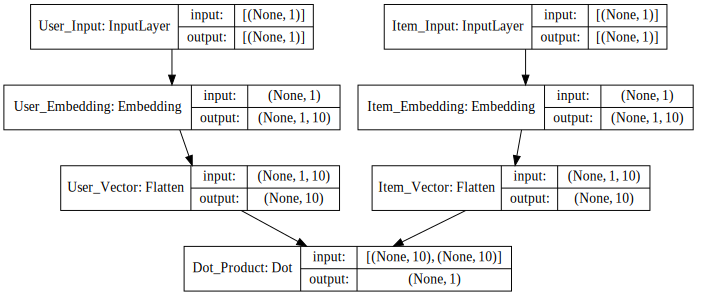

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True, dpi=70 ).create(prog='dot', format='svg'))


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item_Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 10)        66700       User_Input[0][0]                 
__________________________________________________________________________________________________
Item_Embedding (Embedding)      (None, 1, 10)        65840       Item_Input[0][0]                 
______________________________________________________________________________________________

## 2.5) Compiling the Model

In [ ]:
optimizer = Adam(lr = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer, metrics=['mae'])

## 2.6) Fitting the Model

In [ ]:
batch_size = 32
epochs = 50

In [ ]:
x_train.dtypes

item_id    int64
user_id    int64
dtype: object

In [ ]:
history = model.fit(x=[x_train['user_id'], x_train['item_id']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['user_id'], x_test['item_id']], y_test))

Epoch 1/50
1252/1252 - 3s - loss: 18.6473 - mae: 4.1210 - val_loss: 18.5828 - val_mae: 4.1129
Epoch 2/50
1252/1252 - 2s - loss: 18.2412 - mae: 4.0714 - val_loss: 17.6632 - val_mae: 3.9997
Epoch 3/50
1252/1252 - 2s - loss: 16.5933 - mae: 3.8590 - val_loss: 15.5556 - val_mae: 3.7189
Epoch 4/50
1252/1252 - 2s - loss: 14.0757 - mae: 3.5061 - val_loss: 13.0250 - val_mae: 3.3470
Epoch 5/50
1252/1252 - 2s - loss: 11.4351 - mae: 3.0958 - val_loss: 10.6771 - val_mae: 2.9526
Epoch 6/50
1252/1252 - 2s - loss: 9.1798 - mae: 2.6950 - val_loss: 8.8675 - val_mae: 2.5974
Epoch 7/50
1252/1252 - 2s - loss: 7.5022 - mae: 2.3539 - val_loss: 7.6337 - val_mae: 2.3227
Epoch 8/50
1252/1252 - 2s - loss: 6.3294 - mae: 2.0909 - val_loss: 6.8383 - val_mae: 2.1272
Epoch 9/50
1252/1252 - 2s - loss: 5.5032 - mae: 1.8969 - val_loss: 6.3229 - val_mae: 1.9910
Epoch 10/50
1252/1252 - 2s - loss: 4.8947 - mae: 1.7528 - val_loss: 5.9786 - val_mae: 1.8989
Epoch 11/50
1252/1252 - 2s - loss: 4.4212 - mae: 1.6415 - val_loss: 5

In [ ]:
hist_df = pd.DataFrame(history.history) 
hist_df

,loss,mae,val_loss,val_mae
0,18.647346,4.120980,18.582762,4.112945
1,18.241222,4.071372,17.663191,3.999667
2,16.593332,3.858959,15.555592,3.718877
3,14.075733,3.506100,13.025021,3.347031
4,11.435130,3.095844,10.677097,2.952611
5,9.179806,2.694957,8.867469,2.597402
6,7.502203,2.353875,7.633668,2.322744
7,6.329397,2.090860,6.838292,2.127221
8,5.503214,1.896881,6.322919,1.991014
9,4.894662,1.752813,5.978587,1.898912


## 2.7) Plotting Validation Curves

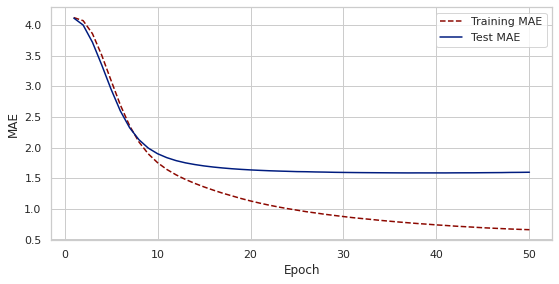

In [ ]:
# Get training and test mae histories
training_mae = history.history['mae']
test_mae = history.history['val_mae']

# Create count of the number of epochs
epoch_count = range(1, len(training_mae) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_mae, 'r--')
plt.plot(epoch_count, test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

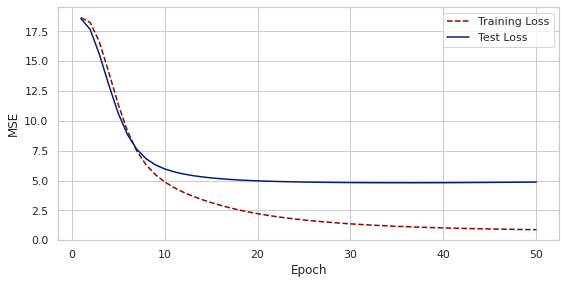

In [ ]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

## 2.8) Evaluating RMSE

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['item_id']], y_test)
score

313/313 [==============================] - 0s 756us/step - loss: 4.8734 - mae: 1.5962


[4.873420238494873, 1.5961724519729614]

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['item_id']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score[0])))

313/313 [==============================] - 0s 781us/step - loss: 4.8734 - mae: 1.5962

RMSE: 2.2076


In [ ]:
model.save('Models/modelDL1')

INFO:tensorflow:Assets written to: Models/modelDL1/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('Models/modelDL1')

## 2.9) Architecture 2

In [ ]:
# Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Items Embeddings
item_input = Input(shape=(1,), name='Item_Input')
item_embeddings = Embedding(input_dim = n_items, output_dim=n_latent_factors, input_length=1, 
                               name='Item_Embedding') (item_input)
item_vector = Flatten(name='Item_Vector') (item_embeddings)


# Concatenate Product
merged_vectors = concatenate([user_vector, item_vector], name='Concantenate')
dense_layer_1 = Dense(20, activation='sigmoid')(merged_vectors) 
# dense_layer_1 = Dropout(0.25) (dense_layer_1)
# batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
# dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, item_input], result)

## 2.10) Visualizing the Model Architecture

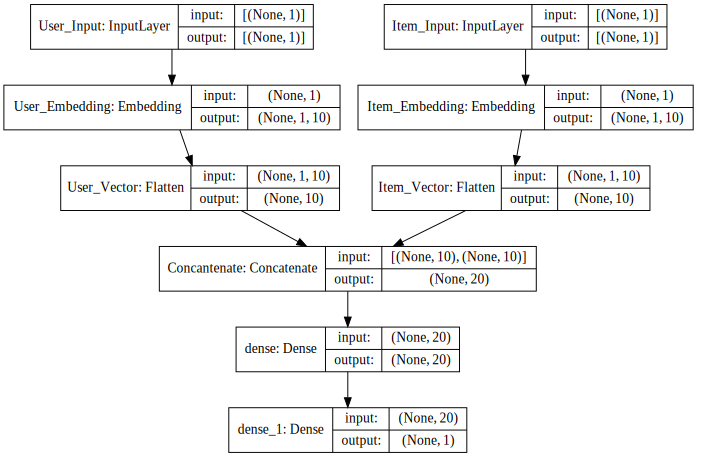

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True, dpi=70 ).create(prog='dot', format='svg'))


In [ ]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item_Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 10)        66700       User_Input[0][0]                 
__________________________________________________________________________________________________
Item_Embedding (Embedding)      (None, 1, 10)        65840       Item_Input[0][0]                 
____________________________________________________________________________________________

## 2.11) Compiling the Model

In [ ]:
optimizer = Adam(lr=0.0002)


In [ ]:
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse','mae'])


## 2.12) Fitting the Model

In [ ]:

batch_size = 32
epochs = 50

In [ ]:
history = model.fit(x=[x_train['user_id'], x_train['item_id']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['user_id'], x_test['item_id']], y_test))

Epoch 1/50
1252/1252 - 4s - loss: 13.9199 - mse: 13.9199 - mae: 3.4318 - val_loss: 5.2582 - val_mse: 5.2582 - val_mae: 2.1228
Epoch 2/50
1252/1252 - 3s - loss: 2.6722 - mse: 2.6722 - mae: 1.4589 - val_loss: 1.7390 - val_mse: 1.7390 - val_mae: 1.1053
Epoch 3/50
1252/1252 - 3s - loss: 1.6334 - mse: 1.6334 - mae: 1.0344 - val_loss: 1.6521 - val_mse: 1.6521 - val_mae: 1.0248
Epoch 4/50
1252/1252 - 3s - loss: 1.5471 - mse: 1.5471 - mae: 0.9895 - val_loss: 1.6243 - val_mse: 1.6243 - val_mae: 1.0145
Epoch 5/50
1252/1252 - 3s - loss: 1.4833 - mse: 1.4833 - mae: 0.9644 - val_loss: 1.6132 - val_mse: 1.6132 - val_mae: 1.0151
Epoch 6/50
1252/1252 - 3s - loss: 1.4293 - mse: 1.4293 - mae: 0.9427 - val_loss: 1.6145 - val_mse: 1.6145 - val_mae: 0.9993
Epoch 7/50
1252/1252 - 3s - loss: 1.3833 - mse: 1.3833 - mae: 0.9192 - val_loss: 1.6256 - val_mse: 1.6256 - val_mae: 1.0066
Epoch 8/50
1252/1252 - 3s - loss: 1.3440 - mse: 1.3440 - mae: 0.8994 - val_loss: 1.6418 - val_mse: 1.6418 - val_mae: 1.0080
Epoch 

In [ ]:
hist_df2 = pd.DataFrame(history.history) 
hist_df2

,loss,mse,mae,val_loss,val_mse,val_mae
0,13.919860,13.919860,3.431849,5.258180,5.258180,2.122838
1,2.672154,2.672154,1.458855,1.738974,1.738974,1.105278
2,1.633390,1.633390,1.034419,1.652077,1.652077,1.024794
3,1.547055,1.547055,0.989531,1.624275,1.624275,1.014540
4,1.483329,1.483329,0.964373,1.613221,1.613221,1.015150
5,1.429276,1.429276,0.942722,1.614542,1.614542,0.999301
6,1.383342,1.383342,0.919184,1.625609,1.625609,1.006650
7,1.344029,1.344029,0.899360,1.641807,1.641807,1.007959
8,1.310575,1.310575,0.881406,1.660614,1.660614,1.011111
9,1.281767,1.281767,0.865119,1.679092,1.679092,1.013557


## 2.13) Plotting Validation Curve

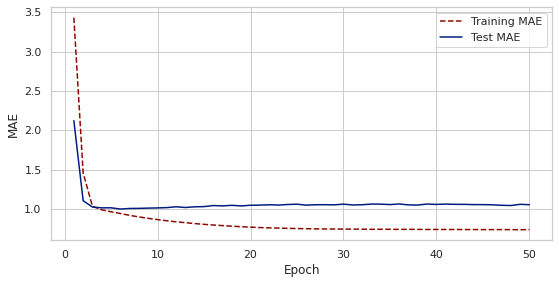

In [ ]:
# Get training and test mae histories
training_mae = history.history['mae']
test_mae = history.history['val_mae']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_mae, 'r--')
plt.plot(epoch_count, test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

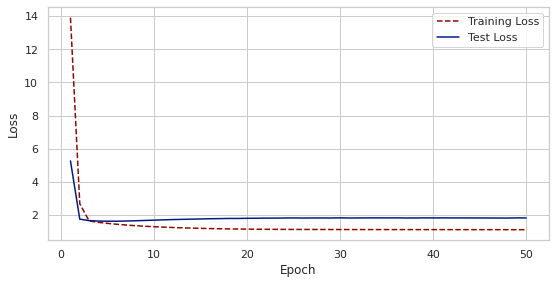

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 2..14) Evaluating RMSE

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['item_id']], y_test)
score

313/313 [==============================] - 0s 916us/step - loss: 1.8119 - mse: 1.8119 - mae: 1.0545


[1.811937689781189, 1.811937689781189, 1.054505705833435]

In [ ]:
score = model.evaluate([x_test['user_id'], x_test['item_id']], y_test)

print()
print('RMSE: {:.4f}'.format(np.sqrt(score[0])))

313/313 [==============================] - 0s 1ms/step - loss: 1.8119 - mse: 1.8119 - mae: 1.0545

RMSE: 1.3461


In [ ]:
model.save('Models/modelDL2')

INFO:tensorflow:Assets written to: Models/modelDL2/assets


## 2.15) Analyze Result


In [ ]:
g=data.groupby('itemId')['rating'].count()
topItems=g.sort_values(ascending=False)[:2000]
topItems = np.array(topItems.index)

In [ ]:
#get embedding
get_item_emb = Model(user_input, user_embeddings)
item_emb = np.squeeze(get_item_emb.predict(data['user_id'].values))
item_emb[user2id['A174NPQZ1EABX1']]

array([ 0.0798418 , -0.13070796, -0.04367679, -0.08072422,  0.07282244,
        0.08491766,  0.07982848, -0.11738676,  0.07322302,  0.07323816],
      dtype=float32)

In [ ]:
import operator
def recommend(user_name):
    user_id = [user2id[user_name]]
    item_id = data[data['userId'] != user_name].item_id.unique()
    predict = {id2item[o]:i for o,i in zip(item_id, model.predict([np.array(user_id*len(item_id)), item_id])[:,0])}
    sorted_predict = sorted(predict.items(), key=operator.itemgetter(1), reverse=True)
    
  
    return(sorted_predict[:10])

In [ ]:
recommend(user_name = 'A174NPQZ1EABX1')

[('B00DLA7I3S', 5.256991),
 ('B074J47Q8H', 5.194009),
 ('B074P8MD22', 5.170208),
 ('B00HZ4EB1S', 5.165174),
 ('B01M5G7WIC', 5.1628604),
 ('B075B1NXKV', 5.1611714),
 ('B016ZGT4KY', 5.157336),
 ('B071G16FZL', 5.156557),
 ('B00R9D5X0I', 5.154977),
 ('B01N44ERGJ', 5.1533494)]

In [ ]:
recommend(user_name = 'A26TQPF0O7PZI3')

[('B00DLA7I3S', 5.256126),
 ('B074J47Q8H', 5.1930504),
 ('B074P8MD22', 5.169163),
 ('B00HZ4EB1S', 5.164185),
 ('B01M5G7WIC', 5.1618285),
 ('B075B1NXKV', 5.160164),
 ('B016ZGT4KY', 5.1563263),
 ('B071G16FZL', 5.1555305),
 ('B00R9D5X0I', 5.153961),
 ('B01N44ERGJ', 5.1523037)]